In [1]:
import math
from decimal import *
import os
import re
import shutil
import sys
import warnings

import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statistics import median

from constants import bins_axis_names, bin_dimensions_regex, boat_speed_feature, \
                    boxplot_axis_name, feature_regex, identifier_features, \
                    fiber_optics_structure_features, fiber_optics_appendix_features, \
                    other_sensor_features, statistics_features, wind_features

In [2]:
def read_csv(fnames):
    """Read CSV file(s) to a Pandas Dataframe"""
    def detect_and_read(fname):
        with open(fname, 'rb') as f:
            return pd.read_csv(fname, sep=';', encoding=chardet.detect(f.read())['encoding'])
    df = pd.concat(map(lambda fname: detect_and_read(fname), fnames), sort=False)
    return df

def preprocess_data(df,
                identifier_cols=identifier_features,
                cols_to_preprocess=fiber_optics_structure_features + fiber_optics_appendix_features,
                other_cols=other_sensor_features + wind_features + [boat_speed_feature],
                regex=feature_regex):
    preprocessed_df = pd.DataFrame()
    cols = identifier_cols + cols_to_preprocess + other_cols
    exclude = identifier_cols + other_cols
    for old_col, new_col in cols: 
        if (old_col, new_col) in exclude: 
            preprocessed_df[new_col] = df[old_col] 
        else:
            filter_regex = regex.format(old_col) 
            preprocessed_df[new_col] = df.filter(regex=(filter_regex)).mean(axis=1)
    return preprocessed_df

In [3]:
# Ignore RunTimeWarning.
warnings.filterwarnings('ignore')

# Ignore PyPlot warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# Version number.
version = 'v2'

In [34]:
#Prend en argument un csv et renvoie un dataframe avec uniquement les données utilisables pour analyser le comportement du bateau
def clean_data(data, min_boat_speed):
        
    df = read_csv(map(lambda fname: data.format(version, fname), ['data-part-1', 'data-part-2']))
    df = preprocess_data(df)
    
    df = df.drop_duplicates()
    
    l1 = len(df)
    
    index_to_be_deleted = []
    
    #Indices pour lesquels le bateau est face au vent
    ind1 = df[(df["Wind_Angle"] < 40) & (df["Wind_Angle"] > -40)].index
    
    #Indices pour lesquels le bateau est en vent arrière
    ind2 = df[((df["Wind_Angle"] < -170) & (df["Wind_Angle"] > -181)) | ((df["Wind_Angle"] > 170) & (df["Wind_Angle"] < 181))].index
    
    #Indices pour lesquels le bateau avance à moins de 5 noeuds
    ind3 = df[df['Boat_Speed'] < min_boat_speed].index
    
    index_to_be_deleted.extend(ind3)
    
    for i1 in ind1:
        index_to_be_deleted.extend(np.arange(i1-600, i1+600))

    for i2 in ind2:
        index_to_be_deleted.extend(np.arange(i2-600, i2+600))

    #On supprime les indices qui apparaissent plusieurs fois
    final_list = list(set(index_to_be_deleted))
    
    l2 = len(final_list)
    
    print(Decimal(l2/l1*100).quantize(Decimal('.1'), rounding=ROUND_HALF_UP),'% des données ont été ignorées')
    
    df = df.drop(final_list, errors = 'ignore')
    
    #On réinitialise les indices
    df = df.reset_index(drop = True)
    
    del_columns = []

    
    for i in df:
        if df[i].count() < 50 :
            del_columns.append(i)
            df = df.drop(i, 1)
    print('Colonnes avec trop de Nan :', del_columns)
    
    col_inf = []
    for i in df.iloc[:,2:]:
        if str(df[i].mean()) == '-inf' or str(df[i].mean()) == 'inf' :
            df = df.drop(i, 1)
            col_inf.append(i)
    print('Colonnes avec que des inf ou -inf :', col_inf)
    
    
    col_with_0 = []
    for i in df.iloc[:,2:]:
        count = 0
        for j in df[i]:
            if j != 0.0:
                count+=1
        if count < 50:
            df = df.drop(i, 1)
            col_with_0.append(i)
    print('Colonnes avec uniquement des 0 :', col_with_0)


    
    return (df)

In [35]:
df = clean_data('datalog-psm2-181002_857_1440_1Hz.csv', 5)

65.8 % des données ont été ignorées
Colonnes avec trop de Nan : ['Central_Rudder_Max_Deformation_Port_1', 'Central_Rudder_Max_Deformation_Port_2', 'Central_Rudder_Max_Deformation_Starboard_1', 'Central_Rudder_Max_Deformation_Starboard_2', 'Central_Rudder_Min_Deformation_Port_1', 'Central_Rudder_Min_Deformation_Port_2', 'Central_Rudder_Min_Deformation_Starboard_1', 'Central_Rudder_Min_Deformation_Starboard_2']
Colonnes avec que des inf ou -inf : ['Max_Port_Front_Beam_A1', 'Max_Port_Front_Beam_B1', 'Max_Port_Front_Beam_C1', 'Max_Port_Front_Beam_D1', 'Min_Port_Front_Beam_A1', 'Min_Port_Front_Beam_B1', 'Min_Port_Front_Beam_C1', 'Min_Port_Front_Beam_D1']
Colonnes avec uniquement des 0 : ['Max_Port_Front_Beam_A4', 'Max_Port_Front_Beam_B4', 'Max_Port_Front_Beam_C4', 'Max_Port_Front_Beam_D4', 'Max_Port_Front_Beam_A2', 'Max_Port_Front_Beam_B2', 'Max_Port_Front_Beam_C2', 'Max_Port_Front_Beam_D2', 'Max_Port_Front_Beam_A3', 'Max_Port_Front_Beam_B3', 'Max_Port_Front_Beam_C3', 'Max_Port_Front_Beam_D

In [36]:
df.head()

,Date,Hour,Latitude,Longitude,Max_Starboard_Front_Beam_A1,Max_Starboard_Front_Beam_B1,Max_Starboard_Front_Beam_C1,Max_Starboard_Front_Beam_D1,Max_Starboard_Front_Beam_A4,Max_Starboard_Front_Beam_B4,...,Selected_Heading,Selected_Heel,Selected_Speed_Over_Ground,Selected_Trim,Wind_Angle,Wind_Direction,Wind_Speed,Apparent_Wind_Angle,Apparent_Wind_Speed,Boat_Speed
0,02/10/2018,05:33:54,47.72668,-3.37009,-50.93577,-34.89704,-6.54777,5.18389,-34.98832,0.25600,...,135.69000,1.26,5.05554,0.09,129.69327,265.38327,3.62308,59.0,3.4,5.05554
1,02/10/2018,05:33:55,47.72667,-3.37007,-51.28154,-36.72329,-5.58167,4.87480,-38.59565,0.61702,...,135.35001,1.39,5.18667,0.12,130.63528,265.98529,3.67733,59.0,3.4,5.18667
2,02/10/2018,05:33:56,47.72665,-3.37004,-49.58827,-37.59818,-5.86057,5.23736,-38.02898,-1.33794,...,134.78999,1.31,5.25108,0.08,131.82915,266.61914,3.73448,59.0,3.3,5.25108
3,02/10/2018,05:33:57,47.72663,-3.37001,-49.65064,-33.70122,-6.43572,4.40576,-34.19328,6.45972,...,134.12000,1.23,5.31479,0.10,133.06879,267.18878,3.78982,59.0,3.3,5.31479
4,02/10/2018,05:33:58,47.72662,-3.36999,-45.94676,-32.03638,-5.45605,3.61902,-32.85263,6.81757,...,133.68001,1.32,5.38544,0.09,133.95802,267.63803,3.83924,59.0,3.3,5.38544


In [37]:
df.describe()

,Latitude,Longitude,Max_Starboard_Front_Beam_A1,Max_Starboard_Front_Beam_B1,Max_Starboard_Front_Beam_C1,Max_Starboard_Front_Beam_D1,Max_Starboard_Front_Beam_A4,Max_Starboard_Front_Beam_B4,Max_Starboard_Front_Beam_C4,Max_Starboard_Front_Beam_D4,...,Selected_Heading,Selected_Heel,Selected_Speed_Over_Ground,Selected_Trim,Wind_Angle,Wind_Direction,Wind_Speed,Apparent_Wind_Angle,Apparent_Wind_Speed,Boat_Speed
count,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,...,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000,16617.000000
mean,47.677917,-4.041080,470.210542,487.142444,243.957649,-59.228253,343.681088,364.108197,176.682569,54.689944,...,199.158527,0.713918,21.818977,0.170344,-17.299656,288.123539,15.058235,-7.474755,25.576777,21.818977
std,0.065075,0.358065,235.303549,222.721762,121.965110,195.834270,209.194088,187.579905,146.331413,352.689448,...,103.900896,6.685171,6.294744,0.599684,94.724957,7.597147,1.947851,45.410697,8.323550,6.294744
min,47.537940,-4.943110,-51.281540,-37.598180,-181.277920,-638.222720,-38.595650,-1.337940,-249.287320,-786.942440,...,0.170010,-15.900000,5.055540,-3.890000,-163.762950,265.383270,3.439740,-159.000000,3.300000,5.055540
25%,47.633260,-4.241780,308.042080,333.934510,161.768910,-243.625730,179.304340,218.044280,50.215320,-294.912630,...,71.050000,-5.780000,18.830760,-0.150000,-129.578080,283.283290,14.193410,-33.000000,21.200000,18.830760
50%,47.671300,-3.940090,388.244230,419.822050,246.049580,59.813790,246.817890,286.876500,169.526600,147.176790,...,229.190000,0.810000,22.006800,0.200000,-48.223480,288.486450,15.242150,-22.000000,27.100000,22.006800
75%,47.724450,-3.848280,690.678770,692.559450,357.276490,105.046770,563.954590,559.082760,324.096220,402.699430,...,248.879990,6.800000,25.688390,0.540000,52.576540,293.108890,16.199260,26.000000,32.200000,25.688390
max,47.817440,-3.366730,1076.183230,1063.350220,473.480870,199.369490,870.922610,840.496340,450.714690,549.420230,...,358.069980,15.570000,36.382500,2.260000,150.745060,312.463840,20.261560,122.000000,39.900000,36.382500


In [38]:
df.to_csv("New_Data_Clean_65%.csv", sep = ';')

In [10]:
indx = df[df["Wind_Angle"] == 0].index


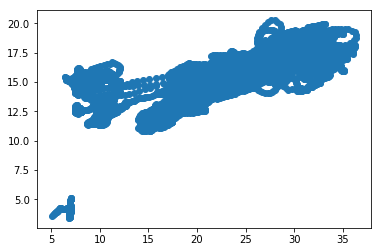

In [42]:
plt.scatter(df['Boat_Speed'], df['Wind_Speed'])

In [12]:
len(indx)

0

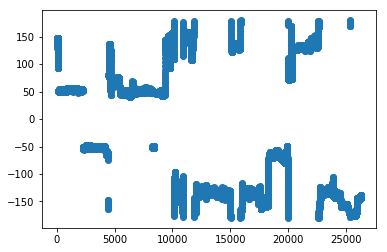

In [24]:
plt.scatter(df['Wind_Angle'].index, df['Wind_Angle'])

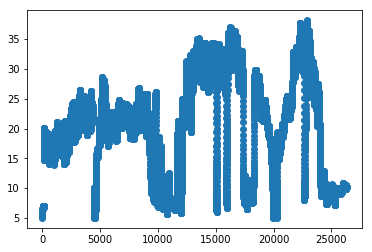

In [25]:
plt.scatter(df['Boat_Speed'].index, df['Boat_Speed'])